# Feature Remove

## Top 8

4가지 방법에서 계산한 특성 중요도를 기반으로, 상위 8개의 특성을 제거 후 성능 측정

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle, resample

from xgboost import XGBClassifier
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [4]:
def make_train_dataset(X_train, seed):
    # upsampling abnormal data
    X_train_normal = X_train[X_train.Class==0]
    X_train_abnormal = X_train[X_train.Class==1]
    
    X_abnormal_res = resample(X_train_abnormal, replace=True, n_samples=X_train_normal.shape[0], random_state=seed)
    X_train = pd.concat([X_train_normal, X_abnormal_res])
    
    y_train = X_train.Class
    X_train = X_train.drop('Class', axis=1)
    
    # shuffle 
    X_res, y_res = shuffle(X_train, y_train, random_state=seed)
    
    return X_res, y_res

In [5]:
# 사전 계산된 특성 중요도 상위 8개
gain_feature_top = ['V14', 'V4', 'V12', 'V8', 'V20', 'Amount', 'V26', 'V15']
cover_feature_top = ['V14', 'V4', 'V20', 'V10', 'V12', 'V1', 'V11', 'V7']
weight_feature_top = ['V14', 'V4', 'V12', 'V16', 'Amount', 'V11', 'V26', 'V10']
shap_feature_top = ['V14', 'V4', 'V12', 'V10', 'V11', 'V16', 'Amount', 'V8']

tops = 8

assert len(gain_feature_top) == tops
assert len(cover_feature_top) == tops
assert len(weight_feature_top) == tops
assert len(shap_feature_top) == tops

In [6]:
result = {'Gain': [],
          'Cover': [],
          'Weight': [],
          'Shap': []}

# repeat: n_iter(50)
for seed in tqdm(range(50)):
    data = pd.read_csv('./creditcard.csv')
    data.drop('Time', axis=1, inplace=True)
    X_train, X_test = train_test_split(data, stratify=data.Class, test_size=0.25, random_state=seed)
    
    ss = StandardScaler()
    X_train['Amount'] = ss.fit_transform(X_train['Amount'].values.reshape(-1, 1))
    X_test['Amount'] = ss.transform(X_test['Amount'].values.reshape(-1, 1))
    
    y_test = X_test.Class
    X_test = X_test.drop('Class', axis=1)
    
    # upsampling
    X_res, y_res = make_train_dataset(X_train, seed)
    
    # feature selection 
    gain_cols = [col for col in X_res.columns if col not in gain_feature_top]
    cover_cols = [col for col in X_res.columns if col not in cover_feature_top]
    weight_cols = [col for col in X_res.columns if col not in weight_feature_top]
    shap_cols = [col for col in X_res.columns if col not in shap_feature_top]
    
    X_res_gain = X_res[gain_cols]
    X_res_cover = X_res[cover_cols]
    X_res_weight = X_res[weight_cols]
    X_res_shap = X_res[shap_cols]
    
    # default hyperparameters 
    xgb_gain = XGBClassifier(seed=seed)
    xgb_cover = XGBClassifier(seed=seed)
    xgb_weight = XGBClassifier(seed=seed)
    xgb_shap = XGBClassifier(seed=seed)
    
    xgb_gain.fit(X_res_gain, y_res)
    xgb_cover.fit(X_res_cover, y_res)
    xgb_weight.fit(X_res_weight, y_res)
    xgb_shap.fit(X_res_shap, y_res)

    result['Gain'].append(f1_score(y_test, xgb_gain.predict(X_test[gain_cols])))
    result['Cover'].append(f1_score(y_test, xgb_cover.predict(X_test[cover_cols])))
    result['Weight'].append(f1_score(y_test, xgb_weight.predict(X_test[weight_cols])))
    result['Shap'].append(f1_score(y_test, xgb_shap.predict(X_test[shap_cols])))

100%|██████████| 50/50 [08:07<00:00,  9.74s/it]


In [7]:
xgb_top_remove_df = pd.DataFrame(result)
xgb_top_remove_df

,Gain,Cover,Weight,Shap
0,0.840708,0.830357,0.833333,0.842105
1,0.876033,0.853659,0.868852,0.866397
2,0.839506,0.855967,0.829876,0.836820
3,0.871795,0.860759,0.859574,0.850000
4,0.839827,0.849785,0.837607,0.841202
5,0.866071,0.853333,0.837838,0.848214
6,0.843882,0.822034,0.818565,0.827004
7,0.841202,0.832618,0.831169,0.822511
8,0.837607,0.843882,0.831933,0.833333
9,0.864629,0.863436,0.869565,0.873362


In [8]:
xgb_top_remove_df.mean()

Gain      0.841808
Cover     0.839702
Weight    0.829431
Shap      0.832319
dtype: float64

In [9]:
xgb_top_remove_df.std()

Gain      0.018333
Cover     0.020833
Weight    0.020314
Shap      0.017811
dtype: float64

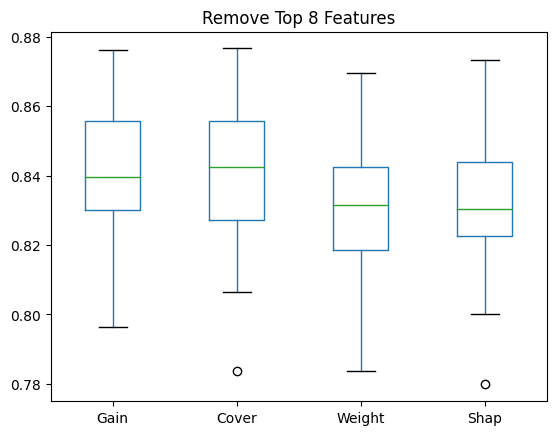

In [10]:
xgb_top_remove_df.boxplot(grid=False)
plt.title('Remove Top ' + str(tops) + ' Features')
plt.show()

In [11]:
xgb_top_remove_df.to_csv('xgb_remove_top8.csv')

# Bottom 8

4가지 방법에서 계산한 특성 중요도를 기반으로, 하위 8개의 특성을 제거 후 성능 측정

In [12]:
# 사전 계산된 특성 중요도 하위 8개
gain_feature_top = ['V5', 'V16', 'V2', 'V21', 'V19', 'V24', 'V1', 'V18']
cover_feature_top = ['V21', 'V2', 'V9', 'V5', 'V28',' V27',' V16', 'V24']
weight_feature_top = ['V5', 'V23',' V20', 'V2', 'V19', 'V25', 'V6', 'V9']
shap_feature_top = ['V2', 'V17', 'V25', 'V20', 'V6', 'V27', 'V7', 'V24']
bottoms = 8

assert len(gain_feature_top) == bottoms
assert len(cover_feature_top) == bottoms
assert len(weight_feature_top) == bottoms
assert len(shap_feature_top) == bottoms

In [13]:
result = {'Gain': [],
          'Cover': [],
          'Weight': [],
          'Shap': []}

# repeat: n_iter(50)
for seed in tqdm(range(50)):
    data = pd.read_csv('./creditcard.csv')
    data.drop('Time', axis=1, inplace=True)
    X_train, X_test = train_test_split(data, stratify=data.Class, test_size=0.25, random_state=seed)
    
    ss = StandardScaler()
    X_train['Amount'] = ss.fit_transform(X_train['Amount'].values.reshape(-1, 1))
    X_test['Amount'] = ss.transform(X_test['Amount'].values.reshape(-1, 1))
    
    y_test = X_test.Class
    X_test = X_test.drop('Class', axis=1)
    
    # upsampling
    X_res, y_res = make_train_dataset(X_train, seed)
    
    # feature selection 
    gain_cols = [col for col in X_res.columns if col not in gain_feature_top]
    cover_cols = [col for col in X_res.columns if col not in cover_feature_top]
    weight_cols = [col for col in X_res.columns if col not in weight_feature_top]
    shap_cols = [col for col in X_res.columns if col not in shap_feature_top]
    
    X_res_gain = X_res[gain_cols]
    X_res_cover = X_res[cover_cols]
    X_res_weight = X_res[weight_cols]
    X_res_shap = X_res[shap_cols]
    
    # default hyperparameters 
    xgb_gain = XGBClassifier(seed=seed)
    xgb_cover = XGBClassifier(seed=seed)
    xgb_weight = XGBClassifier(seed=seed)
    xgb_shap = XGBClassifier(seed=seed)
    
    xgb_gain.fit(X_res_gain, y_res)
    xgb_cover.fit(X_res_cover, y_res)
    xgb_weight.fit(X_res_weight, y_res)
    xgb_shap.fit(X_res_shap, y_res)

    result['Gain'].append(f1_score(y_test, xgb_gain.predict(X_test[gain_cols])))
    result['Cover'].append(f1_score(y_test, xgb_cover.predict(X_test[cover_cols])))
    result['Weight'].append(f1_score(y_test, xgb_weight.predict(X_test[weight_cols])))
    result['Shap'].append(f1_score(y_test, xgb_shap.predict(X_test[shap_cols])))

100%|██████████| 50/50 [08:48<00:00, 10.57s/it]


In [14]:
xgb_bottom_remove_df = pd.DataFrame(result)
xgb_bottom_remove_df

,Gain,Cover,Weight,Shap
0,0.843478,0.864629,0.858369,0.868421
1,0.891667,0.888889,0.892562,0.900826
2,0.872428,0.868852,0.858300,0.887967
3,0.898305,0.898305,0.889831,0.906780
4,0.864407,0.860759,0.872881,0.872881
5,0.862222,0.857143,0.873874,0.884956
6,0.838983,0.829876,0.859574,0.847458
7,0.836207,0.862069,0.829876,0.851064
8,0.860759,0.863071,0.869198,0.869198
9,0.883117,0.860870,0.877193,0.894737


In [15]:
xgb_bottom_remove_df.mean()

Gain      0.854621
Cover     0.855127
Weight    0.858013
Shap      0.860670
dtype: float64

In [16]:
xgb_bottom_remove_df.std()

Gain      0.021969
Cover     0.019672
Weight    0.017173
Shap      0.020087
dtype: float64

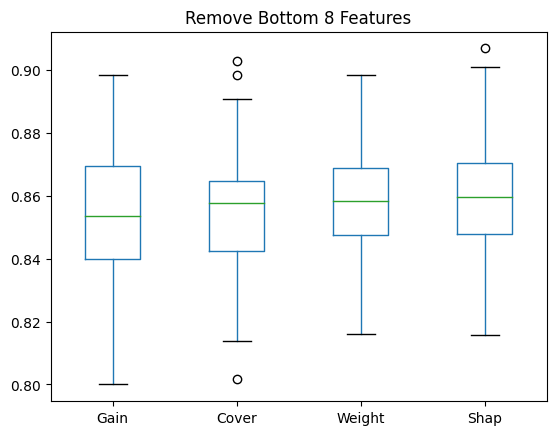

In [17]:
xgb_bottom_remove_df.boxplot(grid=False)
plt.title('Remove Bottom ' + str(bottoms) + ' Features')
plt.show()

In [18]:
xgb_bottom_remove_df.to_csv('xgb_remove_bottom8.csv')